 # Multi-Step Approval Workflow with LangGraph

 This example demonstrates a business approval workflow where requests go through different
 approval stages based on their amount.

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display
from rich import print

 ## Define State

In [2]:
class RequestState(TypedDict):
    request_id: str
    requester: str
    amount: float
    description: str
    manager_approval: str  # "approved", "rejected", "pending"
    director_approval: str  # "approved", "rejected", "pending", "not_required"
    manager_feedback: str
    director_feedback: str
    status: str  # "draft", "submitted", "manager_approved", "manager_rejected", "director_approved", "director_rejected", "completed"

 ## Define Nodes

In [3]:
def submit_request(state: RequestState):
    """Initial step to submit a request"""
    print(f'--- Submitting Request ---')
    print(f'Request ID: {state["request_id"]}')
    print(f'Requester: {state["requester"]}')
    print(f'Amount: ${state["amount"]}')
    print(f'Description: {state["description"]}')
    print('--------------------------')
    return {'status': 'submitted'}


def manager_approval(state: RequestState):
    """Manager approval step with human interrupt"""
    print('--- Manager Approval ---')
    print(f'Reviewing request {state["request_id"]} for ${state["amount"]}')
    print(f'Description: {state["description"]}')

    # For requests >= $1000, manager approval is required
    # For requests < $1000, this step still happens but is simpler
    if state['amount'] >= 1000:
        feedback = interrupt(f'Manager approval needed for ${state["amount"]} request. Approve? (yes/no): ')
        if feedback.lower() in ['yes', 'y', 'approve']:
            return {'manager_approval': 'approved', 'manager_feedback': feedback, 'status': 'manager_approved'}
        else:
            return {'manager_approval': 'rejected', 'manager_feedback': feedback, 'status': 'manager_rejected'}
    else:
        # For smaller amounts, auto-approve but still get feedback
        feedback = interrupt(f'Manager review for ${state["amount"]} request. Any comments? ')
        return {
            'manager_approval': 'approved',
            'manager_feedback': feedback if feedback else 'Auto-approved for small amount',
            'status': 'manager_approved',
        }



In [4]:

def director_approval(state: RequestState):
    """Director approval step with human interrupt (only for large requests)"""
    print('--- Director Approval ---')
    print(f'Director review for request {state["request_id"]} for ${state["amount"]}')

    feedback = interrupt(f'Director approval needed for ${state["amount"]} request. Approve? (yes/no): ')
    if feedback.lower() in ['yes', 'y', 'approve']:
        return {'director_approval': 'approved', 'director_feedback': feedback, 'status': 'director_approved'}
    else:
        return {'director_approval': 'rejected', 'director_feedback': feedback, 'status': 'director_rejected'}


def process_request(state: RequestState):
    """Final processing step"""
    print('--- Processing Request ---')
    print(f'Processing approved request {state["request_id"]}')
    print(f'Final status: {state["status"]}')
    if state.get('manager_feedback'):
        print(f'Manager feedback: {state["manager_feedback"]}')
    if state.get('director_feedback'):
        print(f'Director feedback: {state["director_feedback"]}')
    print('Request processed successfully!')
    return {'status': 'completed'}

 ## Define Conditional Edges

In [5]:
def route_after_manager_approval(state: RequestState):
    """Determine next step after manager approval"""
    # If manager rejected, go to end
    if state['manager_approval'] == 'rejected':
        return 'end'

    # If manager approved, check if director approval is needed
    if state['manager_approval'] == 'approved':
        # Director approval needed for amounts >= $1000
        if state['amount'] >= 1000:
            return 'director_approval'
        else:
            # No director approval needed for smaller amounts
            return 'process_request'

    # Default case
    return 'end'


def route_after_director_approval(state: RequestState):
    """Determine next step after director approval"""
    # If director rejected, go to end
    if state['director_approval'] == 'rejected':
        return 'end'

    # If director approved, proceed to processing
    if state['director_approval'] == 'approved':
        return 'process_request'

    # Default case
    return 'end'

 ## Build and Compile Graph

In [6]:
# Build the graph
builder = StateGraph(RequestState)

# Add nodes
builder.add_node('submit_request', submit_request)
builder.add_node('manager_approval', manager_approval)
builder.add_node('director_approval', director_approval)
builder.add_node('process_request', process_request)

# Add edges
builder.add_edge(START, 'submit_request')
builder.add_edge('submit_request', 'manager_approval')

# Add conditional edges
builder.add_conditional_edges(
    'manager_approval',
    route_after_manager_approval,
    {'director_approval': 'director_approval', 'process_request': 'process_request', 'end': END},
)

builder.add_conditional_edges(
    'director_approval', route_after_director_approval, {'process_request': 'process_request', 'end': END}
)

builder.add_edge('process_request', END)

# Set up memory
memory = InMemorySaver()

# Compile the graph
approval_graph = builder.compile(checkpointer=memory)

 ## Visualize Graph

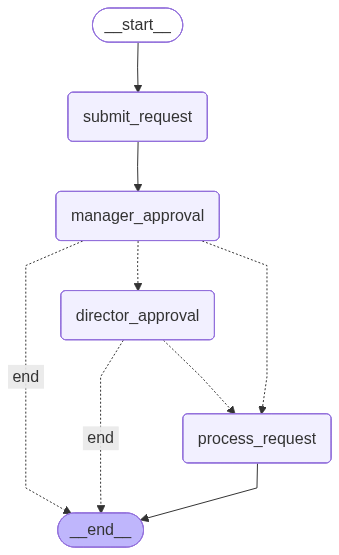

In [7]:
# Visualize the graph
display(Image(approval_graph.get_graph().draw_mermaid_png()))

 ## Test the Workflow

In [ ]:
# Test with a small request (< $1000)
small_request = {
    'request_id': 'REQ-001',
    'requester': 'Alice',
    'amount': 500.0,
    'description': 'Office supplies',
    'manager_approval': 'pending',
    'director_approval': 'pending',
    'status': 'draft',
}

# Test with a large request (>= $1000)
large_request = {
    'request_id': 'REQ-002',
    'requester': 'Bob',
    'amount': 2500.0,
    'description': 'New computer equipment',
    'manager_approval': 'pending',
    'director_approval': 'pending',
    'status': 'draft',
}

# Thread configuration
thread = {'configurable': {'thread_id': 'approval-1'}}

# Run the graph for small request
print('=== Testing Small Request ===')
# In a real notebook, you would run this and then continue after interrupts
for event in approval_graph.stream(small_request, thread, stream_mode='updates'):
    print(f'Event: {event}')
    print()

print('\n=== Testing Large Request ===')
# Run the graph for large request
thread2 = {'configurable': {'thread_id': 'approval-2'}}
for event in approval_graph.stream(large_request, thread2, stream_mode='updates'):
    print(f'Event: {event}')
    print()

# To continue after interrupt, you would use:
# approval_graph.stream(Command(resume="approved"), thread, stream_mode="updates")

=== Testing Small Request ===

--- Submitting Request ---

Request ID: REQ-001

Requester: Alice

Amount: $500.0

Description: Office supplies

--------------------------

Event: {'submit_request': {'status': 'submitted'}}

--- Manager Approval ---

Reviewing request REQ-001 for $500.0

Description: Office supplies

Event: {'__interrupt__': (Interrupt(value='Manager review for $500.0 request. Any comments? ', 
id='b4dc4a91d1f36d1cdde727a8b29a38b6'),)}

=== Testing Large Request ===

--- Submitting Request ---

Request ID: REQ-002

Requester: Bob

Amount: $2500.0

Description: New computer equipment

--------------------------

Event: {'submit_request': {'status': 'submitted'}}

--- Manager Approval ---

Reviewing request REQ-002 for $2500.0

Description: New computer equipment

Event: {'__interrupt__': (Interrupt(value='Manager approval needed for $2500.0 request. Approve? (yes/no): ', 
id='b0e58922b496fb325879ccaacf7a4047'),)}